# Pressure_Tide_White

Test computing pressure offline, making sure I am doing it correctly for closing pressure eqution in DiagDynCSW notebooks

**WARNING** this notebook is completely broken

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr
import crocosi.postp as pp
import crocosi.gridop as gp
from crocosi.vmodes import get_vmodes


/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(dashboard_address=':8787')
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:44797 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


## Load simulation

In [2]:
root_path = '/home/datawork-lops-osi/equinox/jetn/'
run = 'jet_cfg1_wp0_noperturb_0a100j_floats_lev50_itide/'

#gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
grav = 9.81
r = pp.Run(root_path+run, prefix='file_', open_nc=["swath"], verbose=True)


Analysing directory /home/datawork-lops-osi/equinox/jetn/jet_cfg1_wp0_noperturb_0a100j_floats_lev50_itide/
Found 1 segments
Found 1 grid files
Found 10 swath files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['grid', 'swath']
Grid size: (L ,M, N) = (258, 722, 50)


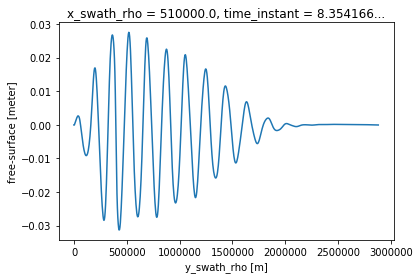

In [3]:
ds = r.ds['swath'].isel(time=400, x_swath_rho=6)
ds.ssh_swath.plot()

In [123]:
_g = 9.81

if True:
    def get_p(grid, rho, zw, zr=None, g=_g):
        """ Compute (not reduced) pressure by integration from the surface, 
        taking rho at rho points and giving results on w points (z grid)
        with p=0 at the surface. If zr is not None, compute result on rho points

        Parameters
        ----------
        ...


        """
        if zr is None:
            print("on w")
            dz = grid.diff(zw, "s")
            p = (grid.cumsum(rho*dz, "s", to="outer", boundary="fill")).assign_coords(z_w=zw)
            p = p.sel(s_w=0) - p # adjust constant so that p is zero at surface
        else:
            # it is assumed that all fields are from bottom to surface
            rna = {"s_w":"s_rho"}
            dpup = (zr - zw.isel(s_w=slice(0,-1)).drop("s_w").rename(rna))*rho
            dpdn = (zw.isel(s_w=slice(1,None)).drop("s_w").rename(rna) - zr)*rho
            p = ((dpup.shift(s_rho=-1, fill_value=0) + dpdn)
                 .sortby(rho.s_rho, ascending=False)                
                 .cumsum("s_rho")
                 .sortby(rho.s_rho, ascending=True)
                 .assign_coords(z_r=zr)
                )
        return _g*p.rename("p")
else:
    get_p = gp.get_p
    
get_z = gp.get_z

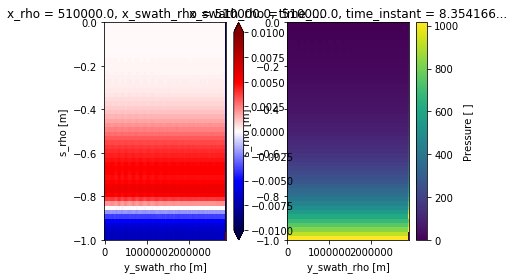

In [124]:
rho0 = r.params_input["rho0"]
grid = r.xgrid
ix = 1

ssh = ds.ssh_swath
T = ds.t_swath
P = ds.P_swath

topo = r['grid'].h.sel(x_rho=ds.x_swath_rho,y_rho=ds.y_swath_rho)
zr = get_z(r, zeta=ssh, h=topo, vgrid='r', hgrid='r').persist()
zw = get_z(r, zeta=ssh, h=topo, vgrid='w', hgrid='r').persist()

pra = get_p(grid, T/rho0, zw, zr) + ssh*_g

fig, axs = plt.subplots(1, 2)
(pra-P).plot(vmin=-.01, vmax=.01, cmap="seismic", ax=axs[0])
P.plot(ax=axs[1])

on w


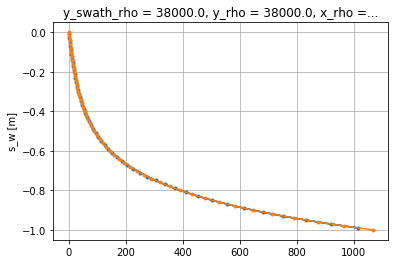

In [125]:
jy = 10

p_rho = pra.isel(y_swath_rho=jy)
p_w = (get_p(grid, T/rho0, zw) + ssh*_g).isel(y_swath_rho=jy)

P.isel(y_swath_rho=jy).plot(y="s_rho", color="k")
p_rho.plot(y="s_rho", marker=".", linestyle=None)
p_w.plot(y="s_w", marker=".", linestyle=None)
plt.grid(True)

## Tests on grid.cumsum
integrate sin(z)

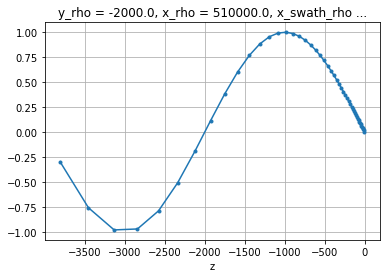

In [100]:
zz = zr.isel(y_swath_rho=0)
Hbot = zw.isel(s_w=0, y_swath_rho=0)
prov = np.sin(2*np.pi*zz/Hbot)
prov = prov.assign_coords(z=zz)
int_ana = -Hbot/2/np.pi*(np.cos(2*np.pi*zz/Hbot).assign_coords(z=zz)-1)

dz = grid.diff(zw.isel(y_swath_rho=0), "s")

prov.plot(x="z", marker=".")
plt.grid(True)

From series, say $v_i$ is the value of the field to integrate (from $i=0$ to $N-1$), $U_i'$ is the forward cumsum with $U_0'=0$ and $U_i''$ the backward cumsum with $U_N'=0$. It is easy to show that :
* $ U_i' = \sum_{j=0}^{i-1}v_j$
* $ U_i'' = \sum{j=i}^{N-1}v_j$
* $ U_N' - U_i' = U_i'' $

From the properties of the integral, we have: 
$$ I_\text{bw}(z) \equiv \int_H^z f(x)dx = \int_0^z f(x)dx + \int_H^0f(x)dx \equiv I_\text{fw}(z) - I_\text{tot} $$

The difference in sign coming from the fact that we should change the sign of $v_i$ in $U''_i$ because of reverted $dz$.

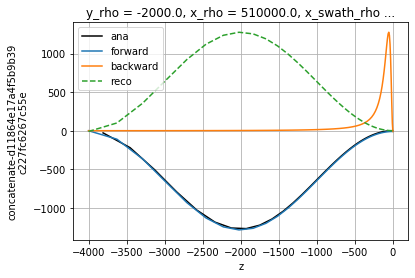

In [116]:
zz = zw.isel(y_swath_rho=0)

int_ana.plot(x="z", color="k", label="ana")
priv = grid.cumsum(prov*dz, "s", to="outer", boundary="fill").assign_coords(z=zz)
prav = grid.cumsum((prov*dz).sortby("s_rho", ascending=False), "s", to="outer", boundary="fill").assign_coords(z=zz)

priv.plot(x="z", label="forward")
prav.plot(x="z", label="backward")
(priv.isel(s_w=-1) - priv).assign_coords(z=zz).plot(x="z", label="reco", linestyle="--")
plt.grid(True)
plt.legend()